# Introduction

We are tasked with training a feed forward neural network using only Pandas and Numpy on the Fashion MNIST dataset. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import feedforwardnn
wandb.login()

2023-03-19 16:30:29.748031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib
2023-03-19 16:30:29.748091: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cs20b075. Use `wandb login --relogin` to force relogin


True

In [3]:
def load_data(dataset):
    (x_train, y_train), (x_test, y_test) = dataset.load_data()
    p = np.random.RandomState().permutation(len(x_train))
    x_train, y_train = x_train[p], y_train[p]
    train_length = int(0.9 * len(x_train))
    x_train, x_val = np.split(x_train, [train_length])
    y_train, y_val = np.split(y_train, [train_length])

    return x_train, y_train, x_val, y_val, x_test, y_test

In [4]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data(fashion_mnist)

## Question 1

Plot one image of every class present in the MNIST dataset.

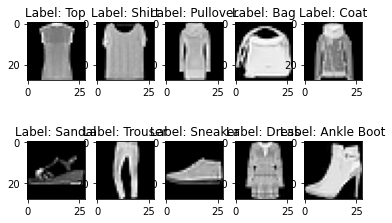

In [6]:
label_map = {0:"Top", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle Boot"}
seen_datasets = set()
wandb.init(project="assignment-1")
figure, axis = plt.subplots(2, 5)
unique_images = []
for index in range(len(x_train)):
    image = x_train[index]
    label = y_train[index]
    if label not in seen_datasets:
        seen_datasets.add(label)
        axis[label%2, label%5].imshow(image, cmap='gray')
        axis[label%2, label%5].set_title(f"Label: {label_map[label]}")
        images = wandb.Image(image, caption=f"Label: {label_map[label]}")
        unique_images.append(images)
wandb.log({"examples": unique_images})


In [5]:
print(y_train[0])

1


In [6]:
def one_hot(X:np.ndarray):
            return np.eye(10)[X]

def process_data(X, Y):
    X = X.reshape(X.shape[0], -1)/255
    Y = one_hot(Y)
    return X, Y

In [7]:
x_train, y_train = process_data(x_train, y_train)
x_val, y_val = process_data(x_val, y_val)
x_test, y_test = process_data(x_test, y_test)

In [16]:
import feedforwardnn

nn = feedforwardnn.FeedforwardNN(784, 10, [64]*5, "relu", "xavier", 0.0001)
opt = feedforwardnn.Momentum(nn.get_params(), 0.001)
opt = feedforwardnn.NAG(nn.get_params(), 0.001)
nn.fit(x_train, y_train, 0.001, 10, 256, opt)

Iteration:  0
Loss:  2.3025899900907834
Iteration:  1
Loss:  2.3025899881039287
Iteration:  2
Loss:  2.30258998611788
Iteration:  3
Loss:  2.3025899841326374
Iteration:  4
Loss:  2.3025899821482003
Iteration:  5
Loss:  2.3025899801645684
Iteration:  6
Loss:  2.3025899781817407
Iteration:  7
Loss:  2.302589976199718
Iteration:  8
Loss:  2.3025899742184994
Iteration:  9
Loss:  2.3025899722380845


In [13]:
print("Accuracy ", nn.accuracy(y_val, nn.predict(x_val)))

Accuracy  0.1025


# Wandb part!

In [11]:
import wandb 

def train(nn:feedforwardnn.FeedforwardNN, opt, config):
    num_epochs= config.epochs

    for epoch in range(num_epochs):
        print("Epoch: ", epoch+1)
        opt.zero_grad()
        print("Iteration ", epoch+1, " of ", num_epochs)
        for index in range(0, len(x_train), config.batch):
            nn.parameters.x_row = x_train[index:index+config.batch]
            nn.parameters.y_row = y_train[index:index+config.batch]
            nn.forward(nn.parameters.x_row)
            nn.backward()
            opt.step()
        y_iter_pred = nn.predict(x_train)
        train_loss = nn.cross_entropy_loss(y_train, y_iter_pred, regularization=True)
        train_accuracy = nn.accuracy(y_train, y_iter_pred)
        y_iter_pred = nn.predict(x_val)
        val_loss = nn.cross_entropy_loss(y_val, y_iter_pred)
        val_accuracy = nn.accuracy(y_val, y_iter_pred)
        val_mse_loss = nn.mean_squared_error(y_val, y_iter_pred)
        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "val_mse_loss":val_mse_loss, "epoch": epoch})
        print("Train Loss: ", train_loss, " Train Accuracy: ", train_accuracy, " Val Loss: ", val_loss, "VAl MSE LOSS:" , val_mse_loss, " Val Accuracy: ", val_accuracy)


def wandb_sweep():
        wandb.init(project="assignment-1")
        cf = wandb.config
        wandb_run_name = f"hl_{cf.hidden_layer_size}_nhl_{cf.num_hidden_layers}_af_{cf.activation_function}_wi_{cf.weight_initialisation}_wd_{cf.weight_decay}_opt_{cf.optimizer}_lr_{cf.learning_rate}_bs_{cf.batch}_ep_{cf.epochs}"
        wandb.run.name = wandb_run_name
        wandb.run.save()
        nn = feedforwardnn.FeedforwardNN(784, 10, [wandb.config.hidden_layer_size]*wandb.config.num_hidden_layers, wandb.config.activation_function, wandb.config.weight_initialisation, wandb.config.weight_decay)
        opt_map = {"sgd": feedforwardnn.SGD, "momentum": feedforwardnn.Momentum, "nesterov": feedforwardnn.NAG, "rmsprop": feedforwardnn.RMSProp, "adam": feedforwardnn.Adam, "nadam": feedforwardnn.NAdam}
        opt = opt_map[wandb.config.optimizer](nn.get_params(), wandb.config.learning_rate)
        train(nn, opt, wandb.config)

In [12]:
sweep_config = {
    "method": "bayes",
    "metric": {"goal": "maximize", "name": "val_accuracy"},
    "parameters": {
        "hidden_layer_size": {"values": [32, 64, 128]},
        "num_hidden_layers": {"values": [2, 3, 4, 5]},
        "learning_rate": {"values": [0.001, 0.0001, 0.003, 0.0003]},
        "batch": {"values": [16, 32, 64]},
        "epochs": {"values": [5, 10]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "activation_function": {"values": ["sigmoid", "tanh", "relu"]},
        "weight_decay": {"values": [0, 0.0005, 0.05, 0.5]},
        "weight_initialisation": {"values": ["xavier", "random"]},
    }
}
sweep_id = wandb.sweep(sweep=sweep_config, project="assignment-1")
wandb.agent(sweep_id=sweep_id, function=wandb_sweep, count=10)


Create sweep with ID: byqia87m
Sweep URL: https://wandb.ai/cs20b075/assignment-1/sweeps/byqia87m


wandb: Agent Starting Run: p9uw2x1g with config:
wandb: 	activation_function: relu
wandb: 	batch: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.05
wandb: 	weight_initialisation: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
/home/sooraj/sem/dl/assignment-1/feedforwardnn.py:255: RuntimeWarning: invalid value encountered in subtract
  X = X - np.max(X, axis=1, keepdims=True)


Epoch:  1
Iteration  1  of  10
Train Loss:  nan  Train Accuracy:  0.10031481481481481  Val Loss:  nan VAl MSE LOSS: nan  Val Accuracy:  0.09716666666666667
Epoch:  2
Iteration  2  of  10
Train Loss:  nan  Train Accuracy:  0.10031481481481481  Val Loss:  nan VAl MSE LOSS: nan  Val Accuracy:  0.09716666666666667
Epoch:  3
Iteration  3  of  10
Train Loss:  nan  Train Accuracy:  0.10031481481481481  Val Loss:  nan VAl MSE LOSS: nan  Val Accuracy:  0.09716666666666667
Epoch:  4
Iteration  4  of  10
Train Loss:  nan  Train Accuracy:  0.10031481481481481  Val Loss:  nan VAl MSE LOSS: nan  Val Accuracy:  0.09716666666666667
Epoch:  5
Iteration  5  of  10
Train Loss:  nan  Train Accuracy:  0.10031481481481481  Val Loss:  nan VAl MSE LOSS: nan  Val Accuracy:  0.09716666666666667
Epoch:  6
Iteration  6  of  10
Train Loss:  nan  Train Accuracy:  0.10031481481481481  Val Loss:  nan VAl MSE LOSS: nan  Val Accuracy:  0.09716666666666667
Epoch:  7
Iteration  7  of  10
Train Loss:  nan  Train Accuracy:

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.10031
train_loss,nan
val_accuracy,0.09717
val_loss,nan
val_mse_loss,nan


wandb: Agent Starting Run: boge7d36 with config:
wandb: 	activation_function: relu
wandb: 	batch: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.5209242201940439  Train Accuracy:  0.8200185185185185  Val Loss:  0.5264238500650981 VAl MSE LOSS: 0.26441719565056293  Val Accuracy:  0.8201666666666667
Epoch:  2
Iteration  2  of  10
Train Loss:  0.4598614576229939  Train Accuracy:  0.8382037037037037  Val Loss:  0.47111535490192363 VAl MSE LOSS: 0.23795059330462928  Val Accuracy:  0.8363333333333334
Epoch:  3
Iteration  3  of  10
Train Loss:  0.4011683684592811  Train Accuracy:  0.8551111111111112  Val Loss:  0.41433476230152344 VAl MSE LOSS: 0.2123557571355908  Val Accuracy:  0.8498333333333333
Epoch:  4
Iteration  4  of  10
Train Loss:  0.3747735864778601  Train Accuracy:  0.8638148148148148  Val Loss:  0.3916032194408576 VAl MSE LOSS: 0.20096738933093639  Val Accuracy:  0.8613333333333333
Epoch:  5
Iteration  5  of  10
Train Loss:  0.35520552835536734  Train Accuracy:  0.8705740740740741  Val Loss:  0.37695485489960895 VAl MSE LOSS: 0.1932371974096008  Val Accuracy:  0.865833333333333

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇▇▇█
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▇▇▇█▇█
val_loss,█▆▄▃▂▂▂▁▁▁
val_mse_loss,█▆▄▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.89028
train_loss,0.29644
val_accuracy,0.87567
val_loss,0.33726


wandb: Agent Starting Run: i7shv5or with config:
wandb: 	activation_function: tanh
wandb: 	batch: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.5132964728466973  Train Accuracy:  0.8149074074074074  Val Loss:  0.5021635063838019 VAl MSE LOSS: 0.26444164080319515  Val Accuracy:  0.8203333333333334
Epoch:  2
Iteration  2  of  10
Train Loss:  0.4607623944687611  Train Accuracy:  0.8330925925925926  Val Loss:  0.4531486376752391 VAl MSE LOSS: 0.23743961824214804  Val Accuracy:  0.8378333333333333
Epoch:  3
Iteration  3  of  10
Train Loss:  0.4343299879623521  Train Accuracy:  0.843037037037037  Val Loss:  0.4308545490771865 VAl MSE LOSS: 0.22392426043713765  Val Accuracy:  0.8456666666666667
Epoch:  4
Iteration  4  of  10
Train Loss:  0.4091149042592099  Train Accuracy:  0.8532592592592593  Val Loss:  0.41020357352356573 VAl MSE LOSS: 0.21185278454546816  Val Accuracy:  0.8546666666666667
Epoch:  5
Iteration  5  of  10
Train Loss:  0.39996237691966036  Train Accuracy:  0.8560185185185185  Val Loss:  0.40459405900334067 VAl MSE LOSS: 0.20812510794242448  Val Accuracy:  0.856333333333333

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▇▇▇████
train_loss,█▅▄▂▂▂▁▁▁▁
val_accuracy,▁▄▅▇▇▇▇▇██
val_loss,█▅▃▂▁▁▁▁▁▁
val_mse_loss,█▅▃▂▁▁▁▁▁▁
epoch,9
train_accuracy,0.86156
train_loss,0.38754
val_accuracy,0.8605
val_loss,0.40222


wandb: Agent Starting Run: b6mtlgw9 with config:
wandb: 	activation_function: relu
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  2.3025850929940437  Train Accuracy:  0.10031481481481481  Val Loss:  2.3025850929940432 VAl MSE LOSS: 0.9000000000000001  Val Accuracy:  0.09716666666666667
Epoch:  2
Iteration  2  of  10
Train Loss:  2.3025850929940437  Train Accuracy:  0.10031481481481481  Val Loss:  2.3025850929940432 VAl MSE LOSS: 0.9000000000000001  Val Accuracy:  0.09716666666666667
Epoch:  3
Iteration  3  of  10
Train Loss:  2.3025850929940437  Train Accuracy:  0.10031481481481481  Val Loss:  2.3025850929940432 VAl MSE LOSS: 0.9000000000000001  Val Accuracy:  0.09716666666666667
Epoch:  4
Iteration  4  of  10
Train Loss:  2.3025850929940437  Train Accuracy:  0.10031481481481481  Val Loss:  2.3025850929940432 VAl MSE LOSS: 0.9000000000000001  Val Accuracy:  0.09716666666666667
Epoch:  5
Iteration  5  of  10
Train Loss:  2.3025850929940437  Train Accuracy:  0.10031481481481481  Val Loss:  2.3025850929940432 VAl MSE LOSS: 0.9000000000000001  Val Accuracy:  0.0971666666666

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
val_mse_loss,▁▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.10031
train_loss,2.30259
val_accuracy,0.09717
val_loss,2.30259


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8dbtx2ga with config:
wandb: 	activation_function: relu
wandb: 	batch: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.4952819574926147  Train Accuracy:  0.8237037037037037  Val Loss:  0.4972917532793098 VAl MSE LOSS: 0.25344686445272463  Val Accuracy:  0.8216666666666667
Epoch:  2
Iteration  2  of  5
Train Loss:  0.42551539062784866  Train Accuracy:  0.8461296296296297  Val Loss:  0.43782014258900054 VAl MSE LOSS: 0.2261371718798325  Val Accuracy:  0.8423333333333334
Epoch:  3
Iteration  3  of  5
Train Loss:  0.40040800743460203  Train Accuracy:  0.8529074074074074  Val Loss:  0.4157735937017931 VAl MSE LOSS: 0.214451330584326  Val Accuracy:  0.8496666666666667
Epoch:  4
Iteration  4  of  5
Train Loss:  0.3757948636289451  Train Accuracy:  0.8622962962962963  Val Loss:  0.39547267258064583 VAl MSE LOSS: 0.2031079621021188  Val Accuracy:  0.8578333333333333
Epoch:  5
Iteration  5  of  5
Train Loss:  0.35540527345900236  Train Accuracy:  0.8695  Val Loss:  0.37798635322894686 VAl MSE LOSS: 0.19344706658775546  Val Accuracy:  0.8656666666666667


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▅▇█
val_loss,█▅▃▂▁
val_mse_loss,█▅▃▂▁
epoch,4
train_accuracy,0.8695
train_loss,0.35541
val_accuracy,0.86567
val_loss,0.37799


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i76uo34c with config:
wandb: 	activation_function: relu
wandb: 	batch: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0003
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_initialisation: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.6077186353041565  Train Accuracy:  0.7829259259259259  Val Loss:  0.6019112110262667 VAl MSE LOSS: 0.30509647149194546  Val Accuracy:  0.783
Epoch:  2
Iteration  2  of  5
Train Loss:  0.5596390718452547  Train Accuracy:  0.8057592592592593  Val Loss:  0.5556892568425731 VAl MSE LOSS: 0.2819438812284491  Val Accuracy:  0.8068333333333333
Epoch:  3
Iteration  3  of  5
Train Loss:  0.5585978870678368  Train Accuracy:  0.8066666666666666  Val Loss:  0.5560530518568767 VAl MSE LOSS: 0.2817042183449805  Val Accuracy:  0.8056666666666666
Epoch:  4
Iteration  4  of  5
Train Loss:  0.5495815957416962  Train Accuracy:  0.8093333333333333  Val Loss:  0.5468727213933642 VAl MSE LOSS: 0.2771195809989027  Val Accuracy:  0.8101666666666667
Epoch:  5
Iteration  5  of  5
Train Loss:  0.5484827657377062  Train Accuracy:  0.8087592592592593  Val Loss:  0.5448548351088934 VAl MSE LOSS: 0.27643949214353686  Val Accuracy:  0.81


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▇▇██
val_loss,█▂▂▁▁
val_mse_loss,█▂▂▁▁
epoch,4
train_accuracy,0.80876
train_loss,0.54848
val_accuracy,0.81
val_loss,0.54485


wandb: Agent Starting Run: scbu50dw with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_initialisation: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  1.3924913846192424  Train Accuracy:  0.529537037037037  Val Loss:  1.3686966103513187 VAl MSE LOSS: 0.6254162817916652  Val Accuracy:  0.5256666666666666
Epoch:  2
Iteration  2  of  10
Train Loss:  0.9720606200087555  Train Accuracy:  0.6655555555555556  Val Loss:  0.9581543040832351 VAl MSE LOSS: 0.46672941424831377  Val Accuracy:  0.6668333333333333
Epoch:  3
Iteration  3  of  10
Train Loss:  0.8041776673029791  Train Accuracy:  0.7399259259259259  Val Loss:  0.7879831314004485 VAl MSE LOSS: 0.3839428473356804  Val Accuracy:  0.7401666666666666
Epoch:  4
Iteration  4  of  10
Train Loss:  0.709787160575552  Train Accuracy:  0.7791481481481481  Val Loss:  0.694232946788768 VAl MSE LOSS: 0.33436288474095793  Val Accuracy:  0.7811666666666667
Epoch:  5
Iteration  5  of  10
Train Loss:  0.6587643466425515  Train Accuracy:  0.8002407407407407  Val Loss:  0.6453451134328043 VAl MSE LOSS: 0.3081815849456399  Val Accuracy:  0.804
Epoch:  6
Iteration

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇█████
train_loss,█▄▃▂▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▄▃▂▁▁▁▁▁▁
val_mse_loss,█▅▃▂▂▁▁▁▁▁
epoch,9
train_accuracy,0.82417
train_loss,0.60391
val_accuracy,0.82867
val_loss,0.59564


wandb: Agent Starting Run: 54txwklb with config:
wandb: 	activation_function: relu
wandb: 	batch: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.003
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.4235069243184507  Train Accuracy:  0.8492037037037037  Val Loss:  0.4306374340010755 VAl MSE LOSS: 0.22008980184744398  Val Accuracy:  0.85
Epoch:  2
Iteration  2  of  5
Train Loss:  0.41320496881314916  Train Accuracy:  0.853037037037037  Val Loss:  0.4210984274624374 VAl MSE LOSS: 0.2140207181468002  Val Accuracy:  0.8495
Epoch:  3
Iteration  3  of  5
Train Loss:  0.42049928318354024  Train Accuracy:  0.8487592592592592  Val Loss:  0.4268988594653577 VAl MSE LOSS: 0.21978804263140933  Val Accuracy:  0.8471666666666666
Epoch:  4
Iteration  4  of  5
Train Loss:  0.41665657468623263  Train Accuracy:  0.8504259259259259  Val Loss:  0.4267894730214725 VAl MSE LOSS: 0.2201909948000434  Val Accuracy:  0.8481666666666666
Epoch:  5
Iteration  5  of  5
Train Loss:  0.4060685618909883  Train Accuracy:  0.8522592592592593  Val Loss:  0.41544847601375323 VAl MSE LOSS: 0.21476678818280384  Val Accuracy:  0.8496666666666667


epoch,▁▃▅▆█
train_accuracy,▂█▁▄▇
train_loss,█▄▇▅▁
val_accuracy,█▇▁▃▇
val_loss,█▄▆▆▁
val_mse_loss,█▁██▂
epoch,4
train_accuracy,0.85226
train_loss,0.40607
val_accuracy,0.84967
val_loss,0.41545


wandb: Agent Starting Run: plt0kj8b with config:
wandb: 	activation_function: relu
wandb: 	batch: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0003
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.4764003053451971  Train Accuracy:  0.8323333333333334  Val Loss:  0.4678947056135322 VAl MSE LOSS: 0.23745098004289023  Val Accuracy:  0.8338333333333333
Epoch:  2
Iteration  2  of  5
Train Loss:  0.4127978139579394  Train Accuracy:  0.8530925925925926  Val Loss:  0.4132899588423793 VAl MSE LOSS: 0.20967135472728662  Val Accuracy:  0.8543333333333333
Epoch:  3
Iteration  3  of  5
Train Loss:  0.3791697165025227  Train Accuracy:  0.8639259259259259  Val Loss:  0.38748435273756626 VAl MSE LOSS: 0.1977225920848195  Val Accuracy:  0.8616666666666667
Epoch:  4
Iteration  4  of  5
Train Loss:  0.3547957445010345  Train Accuracy:  0.8708888888888889  Val Loss:  0.36864475010888426 VAl MSE LOSS: 0.18870649650700336  Val Accuracy:  0.8691666666666666
Epoch:  5
Iteration  5  of  5
Train Loss:  0.34075495901542574  Train Accuracy:  0.8760740740740741  Val Loss:  0.36155670139861223 VAl MSE LOSS: 0.18446952391279142  Val Accuracy:  0.872


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▁▁
val_mse_loss,█▄▃▂▁
epoch,4
train_accuracy,0.87607
train_loss,0.34075
val_accuracy,0.872
val_loss,0.36156


wandb: Agent Starting Run: wox2f48x with config:
wandb: 	activation_function: relu
wandb: 	batch: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.3746654837132924  Train Accuracy:  0.8641666666666666  Val Loss:  0.38253692987841936 VAl MSE LOSS: 0.19708168551786778  Val Accuracy:  0.8646666666666667
Epoch:  2
Iteration  2  of  5
Train Loss:  0.341460500957854  Train Accuracy:  0.873462962962963  Val Loss:  0.35451538493756063 VAl MSE LOSS: 0.18475017570709493  Val Accuracy:  0.8695
Epoch:  3
Iteration  3  of  5
Train Loss:  0.34024890822087006  Train Accuracy:  0.8736666666666667  Val Loss:  0.3649233465716749 VAl MSE LOSS: 0.1890507653397282  Val Accuracy:  0.8688333333333333
Epoch:  4
Iteration  4  of  5
Train Loss:  0.3255157044652771  Train Accuracy:  0.88  Val Loss:  0.35707888827348044 VAl MSE LOSS: 0.1826890073195095  Val Accuracy:  0.8751666666666666
Epoch:  5
Iteration  5  of  5
Train Loss:  0.32682598416204456  Train Accuracy:  0.8765555555555555  Val Loss:  0.36651874972304344 VAl MSE LOSS: 0.18905488802499532  Val Accuracy:  0.8683333333333333


epoch,▁▃▅▆█
train_accuracy,▁▅▅█▆
train_loss,█▃▃▁▁
val_accuracy,▁▄▄█▃
val_loss,█▁▄▂▄
val_mse_loss,█▂▄▁▄
epoch,4
train_accuracy,0.87656
train_loss,0.32683
val_accuracy,0.86833
val_loss,0.36652


In [13]:
wandb.agent(sweep_id="byqia87m", function=wandb_sweep, count=30)

wandb: Agent Starting Run: jttwxktv with config:
wandb: 	activation_function: tanh
wandb: 	batch: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  1.5247452152763836  Train Accuracy:  0.4211666666666667  Val Loss:  1.511453787747837 VAl MSE LOSS: 0.7132525538521292  Val Accuracy:  0.4226666666666667
Epoch:  2
Iteration  2  of  5
Train Loss:  2.4008715342723312  Train Accuracy:  0.09964814814814815  Val Loss:  2.402472094604423 VAl MSE LOSS: 0.9135766592470624  Val Accuracy:  0.10333333333333333
Epoch:  3
Iteration  3  of  5
Train Loss:  2.401144679459581  Train Accuracy:  0.09966666666666667  Val Loss:  2.40291120146355 VAl MSE LOSS: 0.9136598577879791  Val Accuracy:  0.10333333333333333
Epoch:  4
Iteration  4  of  5
Train Loss:  2.4010771037964576  Train Accuracy:  0.09966666666666667  Val Loss:  2.402849548776484 VAl MSE LOSS: 0.9136426428411514  Val Accuracy:  0.10333333333333333
Epoch:  5
Iteration  5  of  5
Train Loss:  2.4009646195942285  Train Accuracy:  0.09966666666666667  Val Loss:  2.402743628138323 VAl MSE LOSS: 0.9136208284306493  Val Accuracy:  0.10333333333333333


epoch,▁▃▅▆█
train_accuracy,█▁▁▁▁
train_loss,▁████
val_accuracy,█▁▁▁▁
val_loss,▁████
val_mse_loss,▁████
epoch,4
train_accuracy,0.09967
train_loss,2.40096
val_accuracy,0.10333
val_loss,2.40274


wandb: Agent Starting Run: rmizduxi with config:
wandb: 	activation_function: relu
wandb: 	batch: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.003
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.7574770018718994  Train Accuracy:  0.7058888888888889  Val Loss:  0.7463694465348047 VAl MSE LOSS: 0.36242022411600705  Val Accuracy:  0.7061666666666667
Epoch:  2
Iteration  2  of  10
Train Loss:  1.3503647620368309  Train Accuracy:  0.4408148148148148  Val Loss:  1.313985360868356 VAl MSE LOSS: 0.5996469114091322  Val Accuracy:  0.4538333333333333
Epoch:  3
Iteration  3  of  10
Train Loss:  1.558969434185052  Train Accuracy:  0.2970740740740741  Val Loss:  1.5266357837897127 VAl MSE LOSS: 0.7308830766732629  Val Accuracy:  0.3001666666666667
Epoch:  4
Iteration  4  of  10
Train Loss:  1.253070382855867  Train Accuracy:  0.38514814814814813  Val Loss:  1.2601187259132525 VAl MSE LOSS: 0.6269210866083128  Val Accuracy:  0.38466666666666666
Epoch:  5
Iteration  5  of  10
Train Loss:  1.959525685128005  Train Accuracy:  0.19590740740740742  Val Loss:  1.955769556762314 VAl MSE LOSS: 0.832489318568762  Val Accuracy:  0.19566666666666666
Epoch:

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▅▃▄▂▁▁▁▁▁
train_loss,▁▄▅▃▆█████
val_accuracy,█▅▃▄▂▁▁▁▁▁
val_loss,▁▄▅▃▆█████
val_mse_loss,▁▄▆▄▇█████
epoch,9
train_accuracy,0.10031
train_loss,2.30261
val_accuracy,0.09717
val_loss,2.30259


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e6qjucm8 with config:
wandb: 	activation_function: relu
wandb: 	batch: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.003
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_initialisation: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  2.5624210633616937  Train Accuracy:  0.1761111111111111  Val Loss:  2.57619744742295 VAl MSE LOSS: 0.8828742055693963  Val Accuracy:  0.17766666666666667
Epoch:  2
Iteration  2  of  10
Train Loss:  0.7415720140323948  Train Accuracy:  0.7268148148148148  Val Loss:  0.7311424404221415 VAl MSE LOSS: 0.3757240190747485  Val Accuracy:  0.7185
Epoch:  3
Iteration  3  of  10
Train Loss:  0.7133838439454483  Train Accuracy:  0.7416481481481482  Val Loss:  0.703711628883972 VAl MSE LOSS: 0.36068720421192535  Val Accuracy:  0.7378333333333333
Epoch:  4
Iteration  4  of  10
Train Loss:  0.7180641000310573  Train Accuracy:  0.7424814814814815  Val Loss:  0.7065959353876587 VAl MSE LOSS: 0.3612784426280791  Val Accuracy:  0.7376666666666667
Epoch:  5
Iteration  5  of  10
Train Loss:  0.7053673332374832  Train Accuracy:  0.7401851851851852  Val Loss:  0.6961022147717346 VAl MSE LOSS: 0.35794298208765457  Val Accuracy:  0.736
Epoch:  6
Iteration  6  of  10

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁█████████
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁█████████
val_loss,█▁▁▁▁▁▁▁▁▁
val_mse_loss,█▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.7503
train_loss,0.68431
val_accuracy,0.7455
val_loss,0.67542


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xyudyl6n with config:
wandb: 	activation_function: tanh
wandb: 	batch: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.003
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.848003748220065  Train Accuracy:  0.7173703703703703  Val Loss:  0.8358920117030226 VAl MSE LOSS: 0.4100084907809325  Val Accuracy:  0.7166666666666667
Epoch:  2
Iteration  2  of  5
Train Loss:  0.9625497700797907  Train Accuracy:  0.6427962962962963  Val Loss:  0.9582867337690325 VAl MSE LOSS: 0.47516113140025307  Val Accuracy:  0.6373333333333333
Epoch:  3
Iteration  3  of  5
Train Loss:  0.8487684286906964  Train Accuracy:  0.6907037037037037  Val Loss:  0.8406528665697242 VAl MSE LOSS: 0.41519560697755825  Val Accuracy:  0.69
Epoch:  4
Iteration  4  of  5
Train Loss:  0.8724442931648919  Train Accuracy:  0.675037037037037  Val Loss:  0.8652967863620968 VAl MSE LOSS: 0.43414161330737344  Val Accuracy:  0.6773333333333333
Epoch:  5
Iteration  5  of  5
Train Loss:  0.9177497019767428  Train Accuracy:  0.6560370370370371  Val Loss:  0.9104000680754011 VAl MSE LOSS: 0.4573636619344724  Val Accuracy:  0.6511666666666667


epoch,▁▃▅▆█
train_accuracy,█▁▅▄▂
train_loss,▁█▁▂▅
val_accuracy,█▁▆▅▂
val_loss,▁█▁▃▅
val_mse_loss,▁█▂▄▆
epoch,4
train_accuracy,0.65604
train_loss,0.91775
val_accuracy,0.65117
val_loss,0.9104


wandb: Agent Starting Run: iyddauu5 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0003
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.7577736713325582  Train Accuracy:  0.7277407407407407  Val Loss:  0.7491926260709328 VAl MSE LOSS: 0.38261431388073347  Val Accuracy:  0.7258333333333333
Epoch:  2
Iteration  2  of  10
Train Loss:  0.5587995853027365  Train Accuracy:  0.8000925925925926  Val Loss:  0.5500753794494662 VAl MSE LOSS: 0.28110529037137616  Val Accuracy:  0.7996666666666666
Epoch:  3
Iteration  3  of  10
Train Loss:  0.48575491301740253  Train Accuracy:  0.8251296296296297  Val Loss:  0.48054232849502126 VAl MSE LOSS: 0.24690567971621763  Val Accuracy:  0.8276666666666667
Epoch:  4
Iteration  4  of  10
Train Loss:  0.4497219840207887  Train Accuracy:  0.8384444444444444  Val Loss:  0.4482434427020831 VAl MSE LOSS: 0.23113770488697985  Val Accuracy:  0.838
Epoch:  5
Iteration  5  of  10
Train Loss:  0.425088851911568  Train Accuracy:  0.8480555555555556  Val Loss:  0.4278762242584057 VAl MSE LOSS: 0.22038480159732723  Val Accuracy:  0.8451666666666666
Epoch:  6
It

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇████
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
val_mse_loss,█▄▃▂▂▂▁▁▁▁
epoch,9
train_accuracy,0.87026
train_loss,0.36169
val_accuracy,0.86617
val_loss,0.38324


wandb: Agent Starting Run: 24jcqj2i with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0003
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.7139198540077918  Train Accuracy:  0.7447962962962963  Val Loss:  0.6958640594500318 VAl MSE LOSS: 0.3487682275802895  Val Accuracy:  0.7513333333333333
Epoch:  2
Iteration  2  of  5
Train Loss:  0.6252543228327808  Train Accuracy:  0.7752777777777777  Val Loss:  0.6103356409027852 VAl MSE LOSS: 0.30944204466081754  Val Accuracy:  0.7818333333333334
Epoch:  3
Iteration  3  of  5
Train Loss:  0.5827088145662255  Train Accuracy:  0.7900925925925926  Val Loss:  0.5700120816815726 VAl MSE LOSS: 0.28990710128703795  Val Accuracy:  0.797
Epoch:  4
Iteration  4  of  5
Train Loss:  0.5548892081136578  Train Accuracy:  0.7994074074074075  Val Loss:  0.5452194732307624 VAl MSE LOSS: 0.27772016848522524  Val Accuracy:  0.8066666666666666
Epoch:  5
Iteration  5  of  5
Train Loss:  0.5338234505881809  Train Accuracy:  0.807037037037037  Val Loss:  0.5271783732641846 VAl MSE LOSS: 0.2686893602380607  Val Accuracy:  0.8125


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
val_mse_loss,█▅▃▂▁
epoch,4
train_accuracy,0.80704
train_loss,0.53382
val_accuracy,0.8125
val_loss,0.52718


wandb: Agent Starting Run: hxdz8we2 with config:
wandb: 	activation_function: tanh
wandb: 	batch: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.4887236691162228  Train Accuracy:  0.829037037037037  Val Loss:  0.4823976620293998 VAl MSE LOSS: 0.24261748989192164  Val Accuracy:  0.8311666666666667
Epoch:  2
Iteration  2  of  10
Train Loss:  0.4249851507768101  Train Accuracy:  0.8486111111111111  Val Loss:  0.4249121163816028 VAl MSE LOSS: 0.21580278726732202  Val Accuracy:  0.85
Epoch:  3
Iteration  3  of  10
Train Loss:  0.400898799347357  Train Accuracy:  0.8575  Val Loss:  0.4055781575724788 VAl MSE LOSS: 0.2060598617508321  Val Accuracy:  0.8568333333333333
Epoch:  4
Iteration  4  of  10
Train Loss:  0.3865357080789971  Train Accuracy:  0.8631851851851852  Val Loss:  0.39427814702230424 VAl MSE LOSS: 0.2002862260483696  Val Accuracy:  0.8608333333333333
Epoch:  5
Iteration  5  of  10
Train Loss:  0.37668358640640415  Train Accuracy:  0.8662407407407408  Val Loss:  0.3865411996850595 VAl MSE LOSS: 0.19637872015511315  Val Accuracy:  0.8623333333333333
Epoch:  6
Iteration  6  of  

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
val_mse_loss,█▅▃▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.87593
train_loss,0.35089
val_accuracy,0.869
val_loss,0.36689


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iuf4noo4 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.48188707825069965  Train Accuracy:  0.8301296296296297  Val Loss:  0.4768003987222137 VAl MSE LOSS: 0.2434227852693837  Val Accuracy:  0.8311666666666667
Epoch:  2
Iteration  2  of  10
Train Loss:  0.3829503558234478  Train Accuracy:  0.8630925925925926  Val Loss:  0.3928703354738814 VAl MSE LOSS: 0.2013321564304211  Val Accuracy:  0.8618333333333333
Epoch:  3
Iteration  3  of  10
Train Loss:  0.344616725880775  Train Accuracy:  0.8764074074074074  Val Loss:  0.3649959765901046 VAl MSE LOSS: 0.18869755983594363  Val Accuracy:  0.867
Epoch:  4
Iteration  4  of  10
Train Loss:  0.3224320711330591  Train Accuracy:  0.8832592592592593  Val Loss:  0.3528663320632108 VAl MSE LOSS: 0.18263794541267056  Val Accuracy:  0.8698333333333333
Epoch:  5
Iteration  5  of  10
Train Loss:  0.31110498274115395  Train Accuracy:  0.8865185185185185  Val Loss:  0.34807329730165565 VAl MSE LOSS: 0.17947773713527623  Val Accuracy:  0.8708333333333333
Epoch:  6
Ite

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▆▆▇▇▇████
val_loss,█▄▂▂▁▁▁▁▁▁
val_mse_loss,█▄▂▂▁▁▁▁▁▁
epoch,9
train_accuracy,0.89619
train_loss,0.28434
val_accuracy,0.87783
val_loss,0.34605


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3oduaxkn with config:
wandb: 	activation_function: tanh
wandb: 	batch: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.003
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.750098781101177  Train Accuracy:  0.7241851851851852  Val Loss:  0.754682953831101 VAl MSE LOSS: 0.39388990949130265  Val Accuracy:  0.7168333333333333
Epoch:  2
Iteration  2  of  5
Train Loss:  0.576684136783121  Train Accuracy:  0.7843333333333333  Val Loss:  0.5764061654963446 VAl MSE LOSS: 0.2972065249904122  Val Accuracy:  0.7798333333333334
Epoch:  3
Iteration  3  of  5
Train Loss:  0.6532677987414827  Train Accuracy:  0.774425925925926  Val Loss:  0.6458715850255055 VAl MSE LOSS: 0.3244239614246289  Val Accuracy:  0.7666666666666667
Epoch:  4
Iteration  4  of  5
Train Loss:  0.7597380017225634  Train Accuracy:  0.7741296296296296  Val Loss:  0.7497536918599595 VAl MSE LOSS: 0.3445999243925973  Val Accuracy:  0.7736666666666666
Epoch:  5
Iteration  5  of  5
Train Loss:  0.5900016655523665  Train Accuracy:  0.7975740740740741  Val Loss:  0.5727824294125657 VAl MSE LOSS: 0.2904803744452619  Val Accuracy:  0.798


epoch,▁▃▅▆█
train_accuracy,▁▇▆▆█
train_loss,█▁▄█▂
val_accuracy,▁▆▅▆█
val_loss,█▁▄█▁
val_mse_loss,█▁▃▅▁
epoch,4
train_accuracy,0.79757
train_loss,0.59
val_accuracy,0.798
val_loss,0.57278


wandb: Agent Starting Run: dx01wjb7 with config:
wandb: 	activation_function: relu
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.5082972173348989  Train Accuracy:  0.8183703703703704  Val Loss:  0.4985215289592159 VAl MSE LOSS: 0.25536817200612133  Val Accuracy:  0.8225
Epoch:  2
Iteration  2  of  10
Train Loss:  0.42059989150763194  Train Accuracy:  0.8483333333333334  Val Loss:  0.4246132461664245 VAl MSE LOSS: 0.21819086771525062  Val Accuracy:  0.8456666666666667
Epoch:  3
Iteration  3  of  10
Train Loss:  0.37309109450363254  Train Accuracy:  0.8648518518518519  Val Loss:  0.38456690625509077 VAl MSE LOSS: 0.19747624183192408  Val Accuracy:  0.86
Epoch:  4
Iteration  4  of  10
Train Loss:  0.34490632923515074  Train Accuracy:  0.8740370370370371  Val Loss:  0.3628851343328762 VAl MSE LOSS: 0.18617288617187971  Val Accuracy:  0.866
Epoch:  5
Iteration  5  of  10
Train Loss:  0.32563732107628596  Train Accuracy:  0.8797407407407407  Val Loss:  0.3496731550357587 VAl MSE LOSS: 0.17963376999980407  Val Accuracy:  0.8725
Epoch:  6
Iteration  6  of  10
Train Loss:  0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▆▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
val_mse_loss,█▅▃▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.90083
train_loss,0.26575
val_accuracy,0.8835
val_loss,0.32333


wandb: Agent Starting Run: h0xsis0q with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.8226069880423571  Train Accuracy:  0.6765925925925926  Val Loss:  0.8106511330572131 VAl MSE LOSS: 0.4174863266491908  Val Accuracy:  0.6701666666666667
Epoch:  2
Iteration  2  of  10
Train Loss:  0.6594930166315831  Train Accuracy:  0.7700555555555556  Val Loss:  0.6543503580901179 VAl MSE LOSS: 0.33121834540245715  Val Accuracy:  0.7666666666666667
Epoch:  3
Iteration  3  of  10
Train Loss:  0.5536553000061721  Train Accuracy:  0.7998148148148149  Val Loss:  0.5561398733149545 VAl MSE LOSS: 0.2880340192440687  Val Accuracy:  0.7906666666666666
Epoch:  4
Iteration  4  of  10
Train Loss:  0.5046409195416499  Train Accuracy:  0.8119074074074074  Val Loss:  0.5115999626468991 VAl MSE LOSS: 0.2672248225675161  Val Accuracy:  0.804
Epoch:  5
Iteration  5  of  10
Train Loss:  0.4678341401009127  Train Accuracy:  0.8233518518518519  Val Loss:  0.47526266046281057 VAl MSE LOSS: 0.24836542816512538  Val Accuracy:  0.8166666666666667
Epoch:  6
Itera

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇██
val_loss,█▅▃▃▂▂▁▁▁▁
val_mse_loss,█▅▄▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.86043
train_loss,0.3903
val_accuracy,0.85283
val_loss,0.42224


wandb: Agent Starting Run: 4ygifg5v with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.003
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  2.3142935013065924  Train Accuracy:  0.09962962962962962  Val Loss:  2.3175832254928714 VAl MSE LOSS: 0.9026782216466586  Val Accuracy:  0.10333333333333333
Epoch:  2
Iteration  2  of  10
Train Loss:  2.31419227959826  Train Accuracy:  0.09962962962962962  Val Loss:  2.3174138267631013 VAl MSE LOSS: 0.9026489777294091  Val Accuracy:  0.10333333333333333
Epoch:  3
Iteration  3  of  10
Train Loss:  2.3141866070258628  Train Accuracy:  0.09962962962962962  Val Loss:  2.317403936712135 VAl MSE LOSS: 0.9026472746697156  Val Accuracy:  0.10333333333333333
Epoch:  4
Iteration  4  of  10
Train Loss:  2.314186210149257  Train Accuracy:  0.09962962962962962  Val Loss:  2.3174032416085937 VAl MSE LOSS: 0.9026471549824737  Val Accuracy:  0.10333333333333333
Epoch:  5
Iteration  5  of  10
Train Loss:  2.3141861788056874  Train Accuracy:  0.09962962962962962  Val Loss:  2.317403186699485 VAl MSE LOSS: 0.9026471455277492  Val Accuracy:  0.10333333333333333


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁
val_mse_loss,█▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.09963
train_loss,2.31419
val_accuracy,0.10333
val_loss,2.3174


wandb: Agent Starting Run: dzmxn1t3 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.05
wandb: 	weight_initialisation: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.5938207241834643  Train Accuracy:  0.7909074074074074  Val Loss:  0.5885812541067675 VAl MSE LOSS: 0.29337278609613476  Val Accuracy:  0.7886666666666666
Epoch:  2
Iteration  2  of  5
Train Loss:  0.5244549251438557  Train Accuracy:  0.8171666666666667  Val Loss:  0.5243948415202816 VAl MSE LOSS: 0.2602588677523708  Val Accuracy:  0.8163333333333334
Epoch:  3
Iteration  3  of  5
Train Loss:  0.5071427712917332  Train Accuracy:  0.8226481481481481  Val Loss:  0.5072439004632161 VAl MSE LOSS: 0.25274894019227784  Val Accuracy:  0.8233333333333334
Epoch:  4
Iteration  4  of  5
Train Loss:  0.5132097285078693  Train Accuracy:  0.8200185185185185  Val Loss:  0.5138690929791362 VAl MSE LOSS: 0.2565476690594925  Val Accuracy:  0.8205
Epoch:  5
Iteration  5  of  5
Train Loss:  0.5272190068704676  Train Accuracy:  0.8147777777777778  Val Loss:  0.5289515158582063 VAl MSE LOSS: 0.2647953514895293  Val Accuracy:  0.814


epoch,▁▃▅▆█
train_accuracy,▁▇█▇▆
train_loss,█▂▁▁▃
val_accuracy,▁▇█▇▆
val_loss,█▂▁▂▃
val_mse_loss,█▂▁▂▃
epoch,4
train_accuracy,0.81478
train_loss,0.52722
val_accuracy,0.814
val_loss,0.52895


wandb: Agent Starting Run: vvakf7fn with config:
wandb: 	activation_function: tanh
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.3954354720859453  Train Accuracy:  0.8542777777777778  Val Loss:  0.4053383192255812 VAl MSE LOSS: 0.21071564084261873  Val Accuracy:  0.8535
Epoch:  2
Iteration  2  of  10
Train Loss:  0.3571634276623983  Train Accuracy:  0.8683518518518518  Val Loss:  0.37377739111350844 VAl MSE LOSS: 0.19385481693743986  Val Accuracy:  0.8653333333333333
Epoch:  3
Iteration  3  of  10
Train Loss:  0.35442889272704764  Train Accuracy:  0.8699629629629629  Val Loss:  0.37280521870610317 VAl MSE LOSS: 0.19246738425276555  Val Accuracy:  0.8643333333333333
Epoch:  4
Iteration  4  of  10
Train Loss:  0.3474680360678876  Train Accuracy:  0.872462962962963  Val Loss:  0.3671928966657502 VAl MSE LOSS: 0.18942176244455475  Val Accuracy:  0.8646666666666667
Epoch:  5
Iteration  5  of  10
Train Loss:  0.34251560605345704  Train Accuracy:  0.8745925925925926  Val Loss:  0.36280146411365405 VAl MSE LOSS: 0.1865258009373911  Val Accuracy:  0.87
Epoch:  6
Iteration  6 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇██▇██
train_loss,█▄▃▃▂▂▂▂▁▁
val_accuracy,▁▅▅▅▇██▇▇█
val_loss,█▃▃▂▁▁▂▃▂▂
val_mse_loss,█▃▃▂▁▁▁▂▁▁
epoch,9
train_accuracy,0.87693
train_loss,0.33433
val_accuracy,0.8725
val_loss,0.36714


wandb: Agent Starting Run: jz2nt6u4 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  2.3051602298936804  Train Accuracy:  0.10022222222222223  Val Loss:  2.3047878412935567 VAl MSE LOSS: 0.9004408012948393  Val Accuracy:  0.098
Epoch:  2
Iteration  2  of  5
Train Loss:  2.30504561788602  Train Accuracy:  0.10022222222222223  Val Loss:  2.3046426794058568 VAl MSE LOSS: 0.9004116783551139  Val Accuracy:  0.098
Epoch:  3
Iteration  3  of  5
Train Loss:  2.3049536406101128  Train Accuracy:  0.10022222222222223  Val Loss:  2.3045532197406104 VAl MSE LOSS: 0.900394082408111  Val Accuracy:  0.098
Epoch:  4
Iteration  4  of  5
Train Loss:  2.3049243534328574  Train Accuracy:  0.10022222222222223  Val Loss:  2.3045458101722827 VAl MSE LOSS: 0.900392598147561  Val Accuracy:  0.098
Epoch:  5
Iteration  5  of  5
Train Loss:  2.3049027660073302  Train Accuracy:  0.10022222222222223  Val Loss:  2.3045442832077523 VAl MSE LOSS: 0.9003923680204019  Val Accuracy:  0.098


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▅▂▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▄▁▁▁
val_mse_loss,█▄▁▁▁
epoch,4
train_accuracy,0.10022
train_loss,2.3049
val_accuracy,0.098
val_loss,2.30454


wandb: Agent Starting Run: yuj075f9 with config:
wandb: 	activation_function: relu
wandb: 	batch: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.003
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  nan  Train Accuracy:  0.10031481481481481  Val Loss:  nan VAl MSE LOSS: nan  Val Accuracy:  0.09716666666666667
Epoch:  2
Iteration  2  of  10
Train Loss:  nan  Train Accuracy:  0.10031481481481481  Val Loss:  nan VAl MSE LOSS: nan  Val Accuracy:  0.09716666666666667
Epoch:  3
Iteration  3  of  10
Train Loss:  nan  Train Accuracy:  0.10031481481481481  Val Loss:  nan VAl MSE LOSS: nan  Val Accuracy:  0.09716666666666667
Epoch:  4
Iteration  4  of  10
Train Loss:  nan  Train Accuracy:  0.10031481481481481  Val Loss:  nan VAl MSE LOSS: nan  Val Accuracy:  0.09716666666666667
Epoch:  5
Iteration  5  of  10
Train Loss:  nan  Train Accuracy:  0.10031481481481481  Val Loss:  nan VAl MSE LOSS: nan  Val Accuracy:  0.09716666666666667
Epoch:  6
Iteration  6  of  10
Train Loss:  nan  Train Accuracy:  0.10031481481481481  Val Loss:  nan VAl MSE LOSS: nan  Val Accuracy:  0.09716666666666667
Epoch:  7
Iteration  7  of  10
Train Loss:  nan  Train Accuracy:

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.10031
train_loss,nan
val_accuracy,0.09717
val_loss,nan
val_mse_loss,nan


wandb: Agent Starting Run: fh0mqv57 with config:
wandb: 	activation_function: relu
wandb: 	batch: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.003
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  2.8694000347168895  Train Accuracy:  0.7326851851851852  Val Loss:  2.8213698424948697 VAl MSE LOSS: 0.4666264980869556  Val Accuracy:  0.739
Epoch:  2
Iteration  2  of  10
Train Loss:  0.7598422649337031  Train Accuracy:  0.7477037037037036  Val Loss:  0.7908680957645855 VAl MSE LOSS: 0.357320203029512  Val Accuracy:  0.741
Epoch:  3
Iteration  3  of  10
Train Loss:  0.6867967711236763  Train Accuracy:  0.7193518518518518  Val Loss:  0.7057682652031618 VAl MSE LOSS: 0.3407472674278295  Val Accuracy:  0.7168333333333333
Epoch:  4
Iteration  4  of  10
Train Loss:  0.6093761145401313  Train Accuracy:  0.7807777777777778  Val Loss:  0.6337764940622264 VAl MSE LOSS: 0.3075888587169354  Val Accuracy:  0.7718333333333334
Epoch:  5
Iteration  5  of  10
Train Loss:  0.5366688089379837  Train Accuracy:  0.8012222222222222  Val Loss:  0.5565525300921863 VAl MSE LOSS: 0.2827914189672272  Val Accuracy:  0.7923333333333333
Epoch:  6
Iteration  6  of  10
T

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▂▂▁▄▅▆▆▆██
train_loss,█▂▂▂▁▁▁▁▁▁
val_accuracy,▂▂▁▄▅▆▆▆██
val_loss,█▂▂▂▁▁▁▁▁▁
val_mse_loss,█▅▅▄▃▂▂▂▁▁
epoch,9
train_accuracy,0.85502
train_loss,0.40547
val_accuracy,0.85117
val_loss,0.42954


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nwnatlxj with config:
wandb: 	activation_function: tanh
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  7.467068478427861  Train Accuracy:  0.21007407407407408  Val Loss:  7.630193704884273 VAl MSE LOSS: 1.3675062355544114  Val Accuracy:  0.2065
Epoch:  2
Iteration  2  of  10
Train Loss:  4.812868630887228  Train Accuracy:  0.3322777777777778  Val Loss:  4.9868695975719275 VAl MSE LOSS: 1.1388593745361468  Val Accuracy:  0.31566666666666665
Epoch:  3
Iteration  3  of  10
Train Loss:  3.5367340767396422  Train Accuracy:  0.4026111111111111  Val Loss:  3.7157698937943526 VAl MSE LOSS: 1.0010863443365503  Val Accuracy:  0.385
Epoch:  4
Iteration  4  of  10
Train Loss:  2.791165706022229  Train Accuracy:  0.45396296296296296  Val Loss:  2.9357563912846696 VAl MSE LOSS: 0.8964265484449978  Val Accuracy:  0.43716666666666665
Epoch:  5
Iteration  5  of  10
Train Loss:  2.2785118452372037  Train Accuracy:  0.49798148148148147  Val Loss:  2.3556489195626593 VAl MSE LOSS: 0.7894105322522141  Val Accuracy:  0.49083333333333334
Epoch:  6
Iteration  6  of  

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇▇██
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▅▄▃▂▂▁▁▁▁
val_mse_loss,█▆▅▄▃▃▂▂▁▁
epoch,9
train_accuracy,0.61431
train_loss,1.19792
val_accuracy,0.6085
val_loss,1.27808


wandb: Agent Starting Run: iyo6hk8f with config:
wandb: 	activation_function: relu
wandb: 	batch: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.003
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  5
Train Loss:  0.4019876209041595  Train Accuracy:  0.854037037037037  Val Loss:  0.41406111205351454 VAl MSE LOSS: 0.2124601089264769  Val Accuracy:  0.8535
Epoch:  2
Iteration  2  of  5
Train Loss:  0.374506222477575  Train Accuracy:  0.8640925925925926  Val Loss:  0.39537825461225234 VAl MSE LOSS: 0.20185100536895317  Val Accuracy:  0.8566666666666667
Epoch:  3
Iteration  3  of  5
Train Loss:  0.39231792464891346  Train Accuracy:  0.8560555555555556  Val Loss:  0.4203842012012317 VAl MSE LOSS: 0.21125211277824535  Val Accuracy:  0.8525
Epoch:  4
Iteration  4  of  5
Train Loss:  0.3666557124567578  Train Accuracy:  0.8666666666666667  Val Loss:  0.3986394321408477 VAl MSE LOSS: 0.20174084075095342  Val Accuracy:  0.8621666666666666
Epoch:  5
Iteration  5  of  5
Train Loss:  0.36733824908681617  Train Accuracy:  0.866537037037037  Val Loss:  0.4015950373341168 VAl MSE LOSS: 0.1989652163006813  Val Accuracy:  0.8631666666666666


epoch,▁▃▅▆█
train_accuracy,▁▇▂██
train_loss,█▃▆▁▁
val_accuracy,▂▄▁▇█
val_loss,▆▁█▂▃
val_mse_loss,█▂▇▂▁
epoch,4
train_accuracy,0.86654
train_loss,0.36734
val_accuracy,0.86317
val_loss,0.4016


wandb: Agent Starting Run: g9pn93t4 with config:
wandb: 	activation_function: tanh
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.41883007077020395  Train Accuracy:  0.8463888888888889  Val Loss:  0.4270905282239913 VAl MSE LOSS: 0.22111838408562096  Val Accuracy:  0.8455
Epoch:  2
Iteration  2  of  10
Train Loss:  0.344694671657608  Train Accuracy:  0.8749629629629629  Val Loss:  0.35692625790927845 VAl MSE LOSS: 0.18420703625382945  Val Accuracy:  0.8723333333333333
Epoch:  3
Iteration  3  of  10
Train Loss:  0.3366114755310415  Train Accuracy:  0.8787592592592592  Val Loss:  0.35414775415659194 VAl MSE LOSS: 0.18220040721971872  Val Accuracy:  0.8755
Epoch:  4
Iteration  4  of  10
Train Loss:  0.34820321867009524  Train Accuracy:  0.8750925925925926  Val Loss:  0.3710558423789402 VAl MSE LOSS: 0.19026385401651977  Val Accuracy:  0.8678333333333333
Epoch:  5
Iteration  5  of  10
Train Loss:  0.33926775461633857  Train Accuracy:  0.8776111111111111  Val Loss:  0.36914142824904883 VAl MSE LOSS: 0.1859539345074157  Val Accuracy:  0.8726666666666667
Epoch:  6
Iteration 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇█▇▇█▇▇██
train_loss,█▃▂▃▂▂▂▂▁▁
val_accuracy,▁▇█▆▇▇▇▆█▇
val_loss,█▁▁▃▂▂▂▂▁▂
val_mse_loss,█▁▁▂▂▂▂▂▁▂
epoch,9
train_accuracy,0.87946
train_loss,0.32851
val_accuracy,0.87183
val_loss,0.36199


wandb: Agent Starting Run: 8obvdt0p with config:
wandb: 	activation_function: relu
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.5339383551685335  Train Accuracy:  0.8108703703703704  Val Loss:  0.5237633455749984 VAl MSE LOSS: 0.2671585017189257  Val Accuracy:  0.8128333333333333
Epoch:  2
Iteration  2  of  10
Train Loss:  0.44994623009365553  Train Accuracy:  0.8397592592592592  Val Loss:  0.44574583022120007 VAl MSE LOSS: 0.22812108328902486  Val Accuracy:  0.8423333333333334
Epoch:  3
Iteration  3  of  10
Train Loss:  0.4144984436871099  Train Accuracy:  0.8520555555555556  Val Loss:  0.41602067071002297 VAl MSE LOSS: 0.21262714018886383  Val Accuracy:  0.851
Epoch:  4
Iteration  4  of  10
Train Loss:  0.3926646555718549  Train Accuracy:  0.8593518518518518  Val Loss:  0.39879017374320747 VAl MSE LOSS: 0.20334428838647742  Val Accuracy:  0.8583333333333333
Epoch:  5
Iteration  5  of  10
Train Loss:  0.377109156937884  Train Accuracy:  0.864574074074074  Val Loss:  0.38776919471246524 VAl MSE LOSS: 0.19758905811800057  Val Accuracy:  0.8626666666666667
Epoch:  6
I

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
val_mse_loss,█▅▄▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.88207
train_loss,0.32643
val_accuracy,0.87517
val_loss,0.35495


wandb: Agent Starting Run: qm6eri0q with config:
wandb: 	activation_function: relu
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.5058397517920203  Train Accuracy:  0.8211666666666667  Val Loss:  0.49655258248203016 VAl MSE LOSS: 0.2542865921230451  Val Accuracy:  0.8238333333333333
Epoch:  2
Iteration  2  of  10
Train Loss:  0.42135006482818754  Train Accuracy:  0.8498703703703704  Val Loss:  0.4257469710438207 VAl MSE LOSS: 0.21763186511985866  Val Accuracy:  0.8486666666666667
Epoch:  3
Iteration  3  of  10
Train Loss:  0.385806231886497  Train Accuracy:  0.8613703703703703  Val Loss:  0.39860970820380626 VAl MSE LOSS: 0.20270052527143945  Val Accuracy:  0.8603333333333333
Epoch:  4
Iteration  4  of  10
Train Loss:  0.36228880135102903  Train Accuracy:  0.8697037037037038  Val Loss:  0.38151154872289333 VAl MSE LOSS: 0.19378211988558253  Val Accuracy:  0.8668333333333333
Epoch:  5
Iteration  5  of  10
Train Loss:  0.3422557933534463  Train Accuracy:  0.8762592592592593  Val Loss:  0.3665049677796281 VAl MSE LOSS: 0.1872330683797325  Val Accuracy:  0.871166666666666

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
val_mse_loss,█▅▄▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.89446
train_loss,0.28711
val_accuracy,0.8785
val_loss,0.33446


wandb: Agent Starting Run: 7pfj5jwh with config:
wandb: 	activation_function: relu
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.003
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.4274709193845067  Train Accuracy:  0.846037037037037  Val Loss:  0.44040902164050144 VAl MSE LOSS: 0.2234038513022687  Val Accuracy:  0.8475
Epoch:  2
Iteration  2  of  10
Train Loss:  0.3891580310891613  Train Accuracy:  0.8558703703703704  Val Loss:  0.41059816038182856 VAl MSE LOSS: 0.210894865116368  Val Accuracy:  0.8546666666666667
Epoch:  3
Iteration  3  of  10
Train Loss:  0.3840284588385782  Train Accuracy:  0.8546851851851852  Val Loss:  0.4046355641829841 VAl MSE LOSS: 0.2075556682713542  Val Accuracy:  0.8551666666666666
Epoch:  4
Iteration  4  of  10
Train Loss:  0.36115815319763295  Train Accuracy:  0.865537037037037  Val Loss:  0.39106572877866613 VAl MSE LOSS: 0.19880709939558228  Val Accuracy:  0.8588333333333333
Epoch:  5
Iteration  5  of  10
Train Loss:  0.34100296724316753  Train Accuracy:  0.8740925925925926  Val Loss:  0.3758518953192823 VAl MSE LOSS: 0.18785470555389816  Val Accuracy:  0.868
Epoch:  6
Iteration  6  of

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▆██▇██▇
train_loss,█▅▅▃▁▁▃▁▁▂
val_accuracy,▁▃▄▅██▆▇▆▆
val_loss,█▅▄▃▁▁▃▁▂▃
val_mse_loss,█▆▅▃▁▁▃▁▂▃
epoch,9
train_accuracy,0.87076
train_loss,0.35057
val_accuracy,0.8615
val_loss,0.39206


wandb: Agent Starting Run: 7ivnab95 with config:
wandb: 	activation_function: tanh
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.4686189878192062  Train Accuracy:  0.8348703703703704  Val Loss:  0.45850689611864315 VAl MSE LOSS: 0.23197510845506644  Val Accuracy:  0.8371666666666666
Epoch:  2
Iteration  2  of  10
Train Loss:  0.39264435221117094  Train Accuracy:  0.859537037037037  Val Loss:  0.3928762217515417 VAl MSE LOSS: 0.2015273318767965  Val Accuracy:  0.8578333333333333
Epoch:  3
Iteration  3  of  10
Train Loss:  0.3594321985116959  Train Accuracy:  0.8709444444444444  Val Loss:  0.3685574855294769 VAl MSE LOSS: 0.1891342187224875  Val Accuracy:  0.8683333333333333
Epoch:  4
Iteration  4  of  10
Train Loss:  0.33812517190805536  Train Accuracy:  0.8775  Val Loss:  0.35363662588713146 VAl MSE LOSS: 0.1817055444281631  Val Accuracy:  0.8746666666666667
Epoch:  5
Iteration  5  of  10
Train Loss:  0.32201730116095184  Train Accuracy:  0.883537037037037  Val Loss:  0.3426640319669153 VAl MSE LOSS: 0.17647826620204585  Val Accuracy:  0.8781666666666667
Epoch:  6
It

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
val_mse_loss,█▅▄▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.90207
train_loss,0.26964
val_accuracy,0.88767
val_loss,0.31297


wandb: Agent Starting Run: coifdyk9 with config:
wandb: 	activation_function: relu
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.003
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.39378777025074874  Train Accuracy:  0.8548333333333333  Val Loss:  0.41492634854141525 VAl MSE LOSS: 0.21283505004287584  Val Accuracy:  0.8538333333333333
Epoch:  2
Iteration  2  of  10
Train Loss:  0.3642064458929735  Train Accuracy:  0.8663888888888889  Val Loss:  0.3886604418601056 VAl MSE LOSS: 0.19649847692760006  Val Accuracy:  0.865
Epoch:  3
Iteration  3  of  10
Train Loss:  0.3461122593865341  Train Accuracy:  0.8712592592592593  Val Loss:  0.36899533416793234 VAl MSE LOSS: 0.18891669637111896  Val Accuracy:  0.868
Epoch:  4
Iteration  4  of  10
Train Loss:  0.34925902578897505  Train Accuracy:  0.8700555555555556  Val Loss:  0.3788680515699763 VAl MSE LOSS: 0.19083443101504544  Val Accuracy:  0.869
Epoch:  5
Iteration  5  of  10
Train Loss:  0.3386093282377606  Train Accuracy:  0.8737037037037036  Val Loss:  0.3744363301145655 VAl MSE LOSS: 0.18898122839646087  Val Accuracy:  0.8666666666666667
Epoch:  6
Iteration  6  of  10
Trai

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▅▆▅▆▅█▇
train_loss,█▅▃▄▃▃▃▃▁▂
val_accuracy,▁▆██▇▅▄▅█▄
val_loss,█▄▁▃▂▂▄▆▂▆
val_mse_loss,█▄▂▂▂▃▄▄▁▂
epoch,9
train_accuracy,0.87844
train_loss,0.33101
val_accuracy,0.86083
val_loss,0.39956


wandb: Agent Starting Run: oc8i1ggq with config:
wandb: 	activation_function: relu
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.003
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  1.4572949349536477  Train Accuracy:  0.29074074074074074  Val Loss:  1.4301038725973203 VAl MSE LOSS: 0.7091910797789667  Val Accuracy:  0.303
Epoch:  2
Iteration  2  of  10
Train Loss:  2.0434169201290056  Train Accuracy:  0.10031481481481481  Val Loss:  2.030775639313401 VAl MSE LOSS: 0.8595342553119217  Val Accuracy:  0.09716666666666667
Epoch:  3
Iteration  3  of  10
Train Loss:  2.0400355640397168  Train Accuracy:  0.10031481481481481  Val Loss:  2.031963976604197 VAl MSE LOSS: 0.8638283337255154  Val Accuracy:  0.09716666666666667
Epoch:  4
Iteration  4  of  10
Train Loss:  2.3025819313850464  Train Accuracy:  0.10031481481481481  Val Loss:  2.3025850929940432 VAl MSE LOSS: 0.9000000000000001  Val Accuracy:  0.09716666666666667
Epoch:  5
Iteration  5  of  10
Train Loss:  2.302481136064573  Train Accuracy:  0.10033333333333333  Val Loss:  2.3025850929940432 VAl MSE LOSS: 0.9000000000000001  Val Accuracy:  0.09716666666666667
Epoch:  6
It

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁
train_loss,▁▆▆███████
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,▁▆▆███████
val_mse_loss,▁▇▇███████
epoch,9
train_accuracy,0.1005
train_loss,2.30236
val_accuracy,0.09733
val_loss,2.30227


wandb: Agent Starting Run: 9ocnt07y with config:
wandb: 	activation_function: relu
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.5877536860930394  Train Accuracy:  0.7995925925925926  Val Loss:  0.5742813150441936 VAl MSE LOSS: 0.2898476832612365  Val Accuracy:  0.8063333333333333
Epoch:  2
Iteration  2  of  10
Train Loss:  0.4658112651980297  Train Accuracy:  0.837  Val Loss:  0.4623208238896959 VAl MSE LOSS: 0.2357693160088933  Val Accuracy:  0.8391666666666666
Epoch:  3
Iteration  3  of  10
Train Loss:  0.42266480513532684  Train Accuracy:  0.8503888888888889  Val Loss:  0.4261951591891418 VAl MSE LOSS: 0.21772726431451003  Val Accuracy:  0.8493333333333334
Epoch:  4
Iteration  4  of  10
Train Loss:  0.3965942307799527  Train Accuracy:  0.8590185185185185  Val Loss:  0.40566838438308217 VAl MSE LOSS: 0.20708406127977572  Val Accuracy:  0.8565
Epoch:  5
Iteration  5  of  10
Train Loss:  0.37910619070371276  Train Accuracy:  0.865462962962963  Val Loss:  0.3927976891270994 VAl MSE LOSS: 0.2002294548606851  Val Accuracy:  0.8615
Epoch:  6
Iteration  6  of  10
Train L

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,█▄▃▃▂▂▂▁▁▁
val_mse_loss,█▄▃▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.8832
train_loss,0.32547
val_accuracy,0.8745
val_loss,0.35637


wandb: Agent Starting Run: f06rojb0 with config:
wandb: 	activation_function: relu
wandb: 	batch: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.6456025798931105  Train Accuracy:  0.7771851851851852  Val Loss:  0.6321751293599126 VAl MSE LOSS: 0.31978028477458853  Val Accuracy:  0.778
Epoch:  2
Iteration  2  of  10
Train Loss:  0.5301986822457304  Train Accuracy:  0.819  Val Loss:  0.5183129641907437 VAl MSE LOSS: 0.26226061188781485  Val Accuracy:  0.8205
Epoch:  3
Iteration  3  of  10
Train Loss:  0.4848532836663171  Train Accuracy:  0.8331851851851851  Val Loss:  0.4762326333025854 VAl MSE LOSS: 0.24117338316174472  Val Accuracy:  0.8325
Epoch:  4
Iteration  4  of  10
Train Loss:  0.4590284938182846  Train Accuracy:  0.8411296296296297  Val Loss:  0.45377479757589884 VAl MSE LOSS: 0.22986918324169628  Val Accuracy:  0.8428333333333333
Epoch:  5
Iteration  5  of  10
Train Loss:  0.4416421226607906  Train Accuracy:  0.8465  Val Loss:  0.4395256501004387 VAl MSE LOSS: 0.22275852591979597  Val Accuracy:  0.8455
Epoch:  6
Iteration  6  of  10
Train Loss:  0.4285798391888971  Train Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▅▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
val_mse_loss,█▅▃▃▂▂▂▁▁▁
epoch,9
train_accuracy,0.86285
train_loss,0.39372
val_accuracy,0.86133
val_loss,0.40271


wandb: Agent Starting Run: my071jsk with config:
wandb: 	activation_function: tanh
wandb: 	batch: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.5859305368602025  Train Accuracy:  0.8075  Val Loss:  0.5730376247493799 VAl MSE LOSS: 0.2794664559859312  Val Accuracy:  0.815
Epoch:  2
Iteration  2  of  10
Train Loss:  0.4359372875653467  Train Accuracy:  0.8468333333333333  Val Loss:  0.4268306013210236 VAl MSE LOSS: 0.21570693069969293  Val Accuracy:  0.848
Epoch:  3
Iteration  3  of  10
Train Loss:  0.3941249017043839  Train Accuracy:  0.8595925925925926  Val Loss:  0.39192379853263515 VAl MSE LOSS: 0.19953005614376723  Val Accuracy:  0.8601666666666666
Epoch:  4
Iteration  4  of  10
Train Loss:  0.37094531224723926  Train Accuracy:  0.8675185185185185  Val Loss:  0.37438487771724027 VAl MSE LOSS: 0.19136694555322625  Val Accuracy:  0.8656666666666667
Epoch:  5
Iteration  5  of  10
Train Loss:  0.35451294246093057  Train Accuracy:  0.8727037037037036  Val Loss:  0.36238140165350685 VAl MSE LOSS: 0.1858876150187402  Val Accuracy:  0.8696666666666667
Epoch:  6
Iteration  6  of  10
Trai

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇██
val_loss,█▄▃▂▂▂▂▁▁▁
val_mse_loss,█▄▃▂▂▂▂▁▁▁
epoch,9
train_accuracy,0.891
train_loss,0.30229
val_accuracy,0.88417
val_loss,0.32593


wandb: Agent Starting Run: la6qgamr with config:
wandb: 	activation_function: tanh
wandb: 	batch: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_initialisation: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1
Iteration  1  of  10
Train Loss:  0.5439084642644384  Train Accuracy:  0.8166666666666667  Val Loss:  0.5313919211268948 VAl MSE LOSS: 0.26291821266044957  Val Accuracy:  0.8201666666666667
Epoch:  2
Iteration  2  of  10
Train Loss:  0.4352297743224541  Train Accuracy:  0.8468518518518519  Val Loss:  0.4291113394894258 VAl MSE LOSS: 0.21733752157014669  Val Accuracy:  0.8478333333333333
Epoch:  3
Iteration  3  of  10
Train Loss:  0.4015597563700619  Train Accuracy:  0.8569814814814815  Val Loss:  0.40227220584936063 VAl MSE LOSS: 0.2047957496790581  Val Accuracy:  0.8566666666666667
Epoch:  4
Iteration  4  of  10
Train Loss:  0.38265427450379186  Train Accuracy:  0.863574074074074  Val Loss:  0.3886438687135193 VAl MSE LOSS: 0.1981608106494372  Val Accuracy:  0.8635
Epoch:  5
Iteration  5  of  10
Train Loss:  0.36946560580868076  Train Accuracy:  0.8678148148148148  Val Loss:  0.3794583192339143 VAl MSE LOSS: 0.1935872624586119  Val Accuracy:  0.8661666666666666
Epoch:  6
Ite

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁
val_mse_loss,█▄▃▂▂▂▁▁▁▁
epoch,9
train_accuracy,0.881
train_loss,0.3342
val_accuracy,0.87383
val_loss,0.35512


# Test data

We now run the best model found so far on the test data.

In [10]:
# Running the best model on the test data
# 128 nodes in 4 hidden layers with tanh and xavier and weight decay as 0
# Using NAdam as the optimizer
nn = feedforwardnn.FeedforwardNN(784, 10, [128]*4, "tanh", "xavier", 0, "cross_entropy")
opt = feedforwardnn.NAdam(nn.get_params(), 0.0001)
nn.fit(x_train, y_train, 10, 64, opt)
y_test_pred = nn.predict(x_test)
print("Test data accuracy:", nn.accuracy(y_test, y_test_pred))

Iteration:  0
Loss:  0.4689862359602879
Iteration:  1
Loss:  0.3894605208500243
Iteration:  2
Loss:  0.35557853413998963
Iteration:  3
Loss:  0.3347287340860165
Iteration:  4
Loss:  0.31965380702342455
Iteration:  5
Loss:  0.30757471486695254
Iteration:  6
Loss:  0.297276449017274
Iteration:  7
Loss:  0.28824613184696074
Iteration:  8
Loss:  0.2801725908918954
Iteration:  9
Loss:  0.27282708669885664
Test data accuracy: 0.8754


In [11]:
confusion_matrix = np.zeros((10, 10))
for i in range(y_test.shape[0]):
    confusion_matrix[np.argmax(y_test_pred[i])][np.argmax(y_test[i])] += 1
y_test_label = np.argmax(y_test, axis=1)
for i in range(10):
    confusion_matrix[i] /= (y_test_label == i).sum()

In [21]:
import plotly.figure_factory as ff
z = confusion_matrix
label_map = ["Top","Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
x = y = label_map

# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.075,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.075,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
# fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

In [22]:
run = wandb.init(project="assignment-1", name="test_data_confusion_matrix")
fig.write_html("./test_data_confusion_matrix.html", auto_play=False)
table = wandb.Table(columns=["Input", "Output", "Expected"])
# table.add_data(wandb.Html("./test_data_confusion_matrix.html"))
wandb.log({"confusion_matrix":wandb.Plotly(fig)})
# run.log({"conf_mat": wandb.plot.confusion_matrix(probs=confusion_matrix, y_true=y)})
wandb.finish()

# Checking the performance of MSE vs Cross Entropy

We shall now compare between the two loss functions based on their performances on the best model's hyperparameters.

In [15]:
nn = feedforwardnn.FeedforwardNN(784, 10, [128]*4, "tanh", "xavier", 0, "mean_squared_error")
opt = feedforwardnn.NAdam(nn.get_params(), 0.0001)
nn.fit(x_train, y_train, 10, 64, opt)
y_val_pred = nn.predict(x_val)
print("Validation data accuracy:", nn.accuracy(y_val, y_val_pred))

Iteration:  0
Loss:  0.49060961297823463
Iteration:  1
Loss:  0.41943896599163916
Iteration:  2
Loss:  0.38617520237145425
Iteration:  3
Loss:  0.3651222405264239
Iteration:  4
Loss:  0.3501616961634373
Iteration:  5
Loss:  0.3386782564334284
Iteration:  6
Loss:  0.32959168177268905
Iteration:  7
Loss:  0.32192558909227303
Iteration:  8
Loss:  0.3149940847985459
Iteration:  9
Loss:  0.30938218772704035
Validation data accuracy: 0.8836666666666667


In [16]:
# Running the best model on the test data
y_test_pred = nn.predict(x_test)
print("Test data accuracy:", nn.accuracy(y_test, y_test_pred))

Test data accuracy: 0.872
